## Estimate connective field sampling extent

In [ ]:
%load_ext autoreload
%autoreload 2
from vicsompy.modeling import MssCf
from vicsompy.surface import CiftiHandler
from vicsompy.subject import HcpSubject
import numpy as np
import pandas as pd
from vicsompy.modeling import MssCf
from vicsompy.surface import CiftiHandler
import numpy as np
import pandas as pd
from tqdm import tqdm
ch=CiftiHandler()
from vicsompy.utils import load_plot_pkg_yaml
from vicsompy.vis import Plot
plotviews=load_plot_pkg_yaml()['plotviews']

analysis_name='TEST'
expt_id='movie'
csub='999999'
my_sub=HcpSubject(subject=csub, experiment_id=expt_id) # Initialise subject
my_sub.prepare_out_dirs(analysis_name) # Prepare output directories
nm=MssCf(my_sub,analysis_name=analysis_name) # Initialise sensory_dm object
nm.make_subsurfaces() # Make subsurfaces
    

Define function for defining the sampling extent.

In [ ]:

def quantify_size(profiles: np.ndarray, distance_matrix: np.ndarray):
    """ quantify_size
    Quantifies the sizes of a set of modality profiles
    This is defined as the maximum distance from the peak at which the profile is above half maximum
    """

    # Find the  peak of each profile.
    peaks = np.nanargmax(profiles, axis=0)

    # Get peak value of each profile
    peakvals = np.nanmax(profiles, axis=0)

    # Create a mask corresponding to parts of the profile that are larger than the HM.
    ismore = profiles > (peakvals/2)[np.newaxis, :]
    abovehm = np.sum(ismore, axis=0)

    # Index distances matrix relative to the peak of each profile.
    peakdistmat = distance_matrix[peaks, :]

    # Distances less than the HM are nan.
    peakdistmat[np.invert(ismore.T)] = np.nan

    # 0 distances are also nan.
    peakdistmat[peakdistmat == 0] = np.nan

    # Distances in the opposite hemisphere are nan.
    peakdistmat[peakdistmat == np.inf] = np.nan

    # what is the maximum distance where the profile is above its half maximum?
    maxdist_above_hm = np.nanmedian(peakdistmat, axis=1)
    return maxdist_above_hm

def quantify_sizes(obj):
    """ quantify_sizes
    Quantifies the sizes of the modality profiles. This leverages the distance matrix of the subsurface.
    """

    size_frames = [pd.DataFrame(quantify_size(obj.modality_profiles[c], obj.subsurfaces[c].distance_matrix), columns=[
                                        'size_' + v]) for c, v in enumerate(obj.modalities)]

    return size_frames


Loop through subjects to estimate the sampling extent of the connective field.

In [ ]:
s_v=[]
s_s=[]
for sub in tqdm(my_sub.full_data_subjects):
    csub=str(sub)
    my_sub=HcpSubject(subject=csub, experiment_id=expt_id) # Initialise subject
    my_sub.prepare_out_dirs(analysis_name) # Prepare output directories
    nm=MssCf(my_sub,analysis_name=analysis_name) # Initialise sensory_dm object
    nm.make_subsurfaces() # Make subsurfaces
    nm.npy=False
    nm.load_precomputed_betas() # Load precomputed betas.
    nm.reconstruct_profiles() # Reconstruct
    sz=quantify_sizes(nm)
    sv,_=ch.decompose_data(sz[0]['size_visual'])
    ss,_=ch.decompose_data(sz[1]['size_somato'])
    s_v.append(sv)
    s_s.append(ss)    

100%|██████████| 174/174 [1:31:17<00:00, 31.48s/it]


Compute the mean for plotting.

In [ ]:
size_array_visual=np.array(s_v)
size_array_somato=np.array(s_s)
sub_mean=np.nanmean(size_array_visual,axis=0)
sub_mean_som=np.nanmean(size_array_somato,axis=0)

Mask to only show soma and visual areas.

In [4]:
import cortex
rois=['Parietal','Frontal',"Medial","Operculum-insula", "VISPATH_1n",
        "VISPATH_2",
        "VISPATH_3",
        "VISPATH_4_n",
        "VISPATH_5",
        "VISPATH_6n",
        "VISPATH_7",
        "VISPATH_8",
        "VISPATH_1_R",
        "VISPATH_2_R",
        "VISPATH_3_R",
        "VISPATH_4_R",
        "VISPATH_5_R",
        "VISPATH_6_R",
        "VISPATH_7_R",
        "VISPATH_8_R"]
somasks=cortex.utils.get_roi_verts('hcp_999999_draw_NH',rois,mask=True)

cmask=np.sum([somasks[roi] for roi in somasks.keys()],axis=0).astype(bool)

adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:4107022): WARNING **: 14:23:23.962: Fonts dir '/tank/hedger/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)
adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:4107120): WARNING **: 14:23:25.339: Fonts dir '/tank/hedger/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)
adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:4107219): WARNING **: 14:23:26.750: Fonts dir '/tank/hedger/.config/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2511.29:1024 exported to 2511 x 1024 pixels (96 dpi)
adding rois
Unable to init server: Could not connect: Connection refused
** (inkscape:4107435): WARNING **

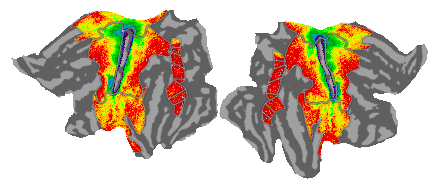

<Figure size 3600x1800 with 0 Axes>

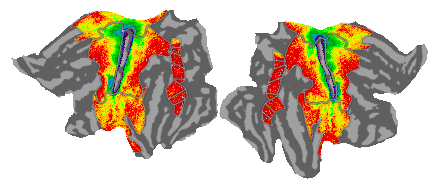

In [7]:
from vicsompy.utils import load_plot_pkg_yaml
from vicsompy.vis import Plot
plotviews=load_plot_pkg_yaml()['plotviews']
mp=Plot(**plotviews['size_som'])

sub_mean_som[nm.subsurfaces[1].subsurface_verts]=np.nan


mp.uber_plot(dat=sub_mean_som,dat2=cmask)